### DESARROLLO MODELO DE ARBOLES ALEATORIOS (RF)

### Cargar los datos ya limpiados y analizados en el Notebook analisis data y cargar librerias necesarias

In [4]:
!pip install -q -U keras-tuner

In [1]:

import numpy as np
import pandas as pd
from keras import backend as K
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
datos=pd.read_csv("Data_clean_Completo4.csv")



### Preprocesamiento de datos

In [2]:

variables_categoricas = ["Cation", "Anion","T_Comportamiento"]
variables_numericas = ["Solute_Mol_Mass", "Num_Cations", "Num_Anions", "Temperature_C", "Solvent_Mol_Mass", "Molal"]
variables_a_predecir = ["Molal_Activity_Coefficient", "Osmotic_Coefficient"]


column_transformer = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(), variables_categoricas),
        ("num", StandardScaler(), variables_numericas)
    ])




### División de datos en conjuntos de entrenamiento y prueba

In [3]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(datos, test_size=0.2, random_state=42, stratify=datos['Id_solucion'])
X_test = column_transformer.fit_transform(test_data[variables_categoricas + variables_numericas])
y_test = test_data[variables_a_predecir].values
X_train = column_transformer.fit_transform(train_data[variables_categoricas + variables_numericas])
y_train = train_data[variables_a_predecir].values
X_train=X_train.toarray()


### Creacion del modelo de RF d y entrenamiento

In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error



models = []
num_outputs = y_train.shape[1]

for i in range(num_outputs):
    model = RandomForestRegressor(n_estimators=300, max_depth=15, min_samples_split=3, random_state=500)
    model.fit(X_train, y_train[:, i])
    models.append(model)
    model.feature
        







### Resumen y guardar modelo RF

In [109]:
model.summary()
#model.save("Model_trained_data_clean_AX1.h5")

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 175)]             0         
                                                                 
 dense_58 (Dense)            (None, 20)                3520      
                                                                 
 dense_59 (Dense)            (None, 15)                315       
                                                                 
 dense_60 (Dense)            (None, 15)                240       
                                                                 
 dense_61 (Dense)            (None, 3)                 48        
                                                                 
Total params: 4,123
Trainable params: 4,123
Non-trainable params: 0
_________________________________________________________________


###  Predicciones en el conjunto de entrenamiento y de prueba

### Graficos de dispersion de valores predichos vs Valores reales

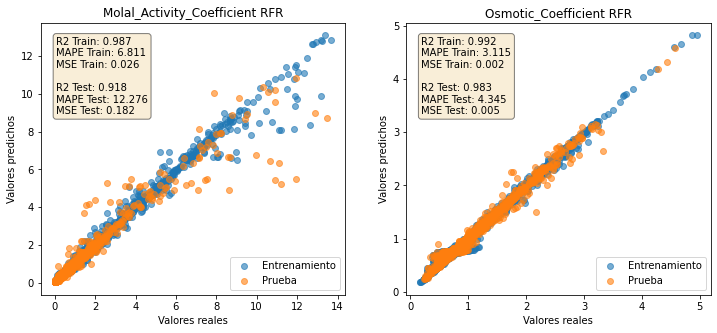

In [5]:
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

y_train_pred = np.zeros(y_train.shape)
y_test_pred = np.zeros(y_test.shape)

for i, model in enumerate(models):
    
    y_train_pred[:, i] = model.predict(X_train)
    y_test_pred[:, i] = model.predict(X_test)


metrics_train = []
metrics_test = []

for i in range(2):
    r2_train = r2_score(y_train[:, i], y_train_pred[:, i])
    mape_train = mean_absolute_percentage_error(y_train[:, i], y_train_pred[:, i])
    mse_train = mean_squared_error(y_train[:, i], y_train_pred[:, i])
    
    r2_test = r2_score(y_test[:, i], y_test_pred[:, i])
    mape_test = mean_absolute_percentage_error(y_test[:, i], y_test_pred[:, i])
    mse_test = mean_squared_error(y_test[:, i], y_test_pred[:, i])
    
    metrics_train.append((r2_train, mape_train, mse_train))
    metrics_test.append((r2_test, mape_test, mse_test))

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for i, ax in enumerate(axes):
    ax.scatter(y_train[:, i], y_train_pred[:, i], alpha=0.6, label="Entrenamiento")
    ax.scatter(y_test[:, i], y_test_pred[:, i], alpha=0.6, label="Prueba")
    
    ax.set_xlabel("Valores reales")
    ax.set_ylabel("Valores predichos")
    ax.set_title(variables_a_predecir[i]+" RFR")
    
   
    metrics_text = f"R2 Train: {metrics_train[i][0]:.3f}\nMAPE Train: {metrics_train[i][1]:.3f}\nMSE Train: {metrics_train[i][2]:.3f}\n\nR2 Test: {metrics_test[i][0]:.3f}\nMAPE Test: {metrics_test[i][1]:.3f}\nMSE Test: {metrics_test[i][2]:.3f}"
    ax.text(0.05, 0.95, metrics_text, transform=ax.transAxes, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    ax.legend(loc='lower right')
plt.savefig("RFR.jpg")
plt.show()

### Histograma de las desviaciones porcentuales PDi (%) del modelo

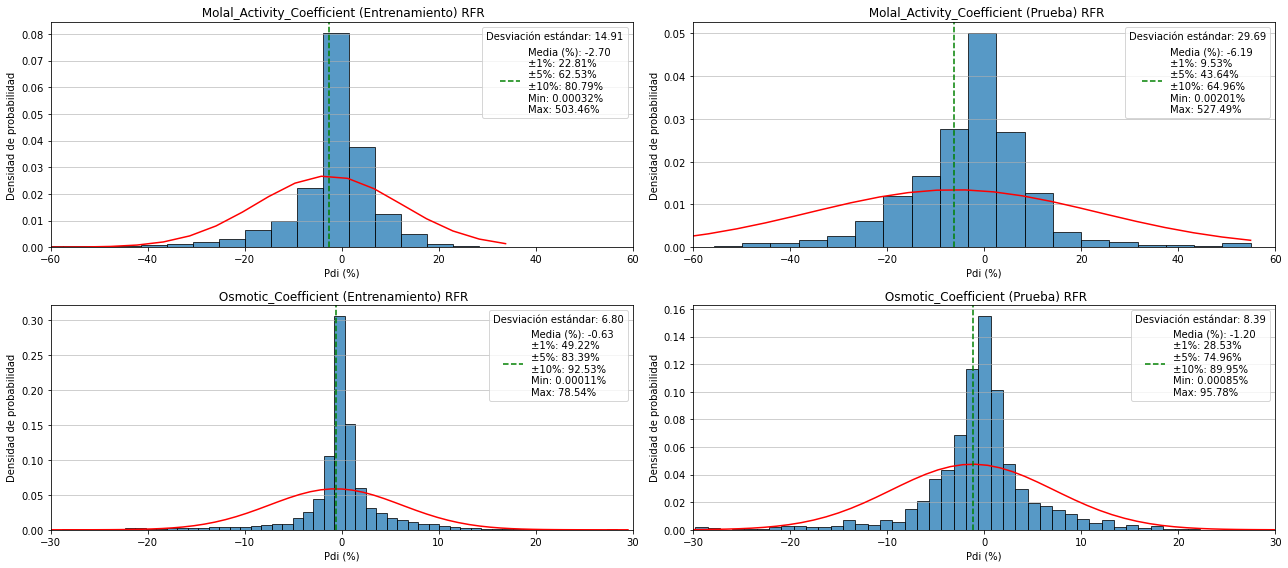

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# Extraer las predicciones por variable
train_pred = y_train_pred
test_pred = y_test_pred

def calculate_error_ranges(errors):
    within_1 = np.sum(np.abs(errors) <= 1) / len(errors) * 100
    within_5 = np.sum(np.abs(errors) <= 5) / len(errors) * 100
    within_10 = np.sum(np.abs(errors) <= 10) / len(errors) * 100
    min_error = np.min(np.abs(errors))
    max_error = np.max(np.abs(errors))
    return within_1, within_5, within_10, min_error, max_error

def plot_relative_errors_histogram(ax, y_true, y_pred, title, xlim):
    errors = (((y_true - y_pred) / y_true) * 100).ravel()
    within_1, within_5, within_10, min_error, max_error = calculate_error_ranges(errors)

    bins = np.linspace(errors.min(), errors.max(), 100)
    density, _, _ = ax.hist(errors, bins=100, density=True, ec='black', alpha=0.75)

    mean = errors.mean()
    std = errors.std()

    normal_dist = stats.norm.pdf(bins, mean, std)
    ax.plot(bins, normal_dist, color='r')

    ax.axvline(mean, color='g', linestyle='--', label=f'Media (%): {mean:.2f}\n±1%: {within_1:.2f}%\n±5%: {within_5:.2f}%\n±10%: {within_10:.2f}%\nMin: {min_error:.5f}%\nMax: {max_error:.2f}%')

    ax.legend(title=f'Desviación estándar: {std:.2f}')

    ax.set_title(title)
    ax.set_xlabel('Pdi (%)')
    ax.set_ylabel('Densidad de probabilidad')
    ax.grid(axis='y', alpha=0.75)
    ax.set_xlim(xlim)

fig, axes = plt.subplots(2, 2, figsize=(18, 8))


limits = [(-60, 60), (-30, 30)]

for i, variable_name in enumerate(variables_a_predecir[:2]):
    plot_relative_errors_histogram(axes[i, 0], y_train[:, i], train_pred[:, i], f' {variable_name} (Entrenamiento) RFR', limits[i])
    plot_relative_errors_histogram(axes[i, 1], y_test[:, i], test_pred[:, i], f' {variable_name} (Prueba) RFR', limits[i])

plt.tight_layout()
plt.savefig("GPR.jpg")
plt.show()

### EVALUACION DE LOS RESULTADOS DEL MODELO POR FAMILIAS

In [10]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

def plot_scatter(ax, y_true_train, y_pred_train, y_true_test, y_pred_test, title):
    ax.scatter(y_true_train, y_pred_train, label='Entrenamiento', alpha=0.5)
    ax.scatter(y_true_test, y_pred_test, label='Prueba', alpha=0.5)
    
    mse_train = mean_squared_error(y_true_train, y_pred_train)
    mse_test = mean_squared_error(y_true_test, y_pred_test)
    r2_train = r2_score(y_true_train, y_pred_train)
    r2_test = r2_score(y_true_test, y_pred_test)
    mape_train = mean_absolute_percentage_error(y_true_train, y_pred_train) * 100
    mape_test = mean_absolute_percentage_error(y_true_test, y_pred_test) * 100
    
    ax.set_title(title)
    ax.set_xlabel('Valores Reales')
    ax.set_ylabel('Valores Predichos')
    ax.legend(loc='lower right')
    
    ax.text(0.05, 0.95, f'MSE (Entrenamiento): {mse_train:.2f}\nMSE (Prueba): {mse_test:.2f}\n'
            f'R2 (Entrenamiento): {r2_train:.2f}\nR2 (Prueba): {r2_test:.2f}\n'
            f'MAPE (Entrenamiento): {mape_train:.2f}%\nMAPE (Prueba): {mape_test:.2f}%',
            transform=ax.transAxes, verticalalignment='top',  bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    


def plot_histogram(ax, y_true_train, y_pred_train, y_true_test, y_pred_test, title):
    relative_errors_train = 100 * ((y_true_train - y_pred_train) / y_true_train)
    relative_errors_test = 100 * ((y_true_test - y_pred_test) / y_true_test)
    relative_errors = np.concatenate([relative_errors_train, relative_errors_test])

    ax.hist(relative_errors, bins=50, alpha=0.5, edgecolor="k", density=True)
    mean = np.mean(relative_errors)
    std = np.std(relative_errors)
    x = np.linspace(mean - 3 * std, mean + 3 * std, 100)
    ax.plot(x, norm.pdf(x, mean, std), label=f'Gaussian (std={std:.2f})')
    
    ax.axvline(mean, color='r', linestyle='--', label=f'Mean: {mean:.2f}%')
    
    percentile_10, percentile_90 = np.percentile(relative_errors, [10, 90])
    ax.axvline(percentile_10, color='g', linestyle='--', label=f'Percentile 10%: {percentile_10:.2f}%')
    ax.axvline(percentile_90, color='b', linestyle='--', label=f'Percentile 90%: {percentile_90:.2f}%')
    ax.set_title(title)
    ax.set_xlabel("Relative error (%)")
    ax.set_ylabel("Frequency")
    lower_limit = np.percentile(relative_errors, 0)
    upper_limit = np.percentile(relative_errors, 100)
    ax.set_xlim(lower_limit, upper_limit) 
    ax.legend(loc='upper left')
    
id_cloruros = [5, 10, 24, 31, 35, 40, 43, 45, 48, 50, 53, 55, 57, 58, 59, 63, 64, 76, 77, 83, 84, 88, 124, 125, 127, 128, 132, 133, 135, 136, 141, 143, 145, 147, 150, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 217, 226, 227, 229, 237, 238, 239, 240, 241, 244, 260, 261, 262, 263, 273, 274, 275, 280, 281, 283, 284, 285, 296, 330]
id_fluoruros = [138, 139, 140, 149, 271, 272, 276, 277, 278, 279, 305, 328]
id_bromuros = [6, 11, 25, 32, 36, 41, 46, 51, 60, 65, 90, 129, 134, 142, 144, 146, 151, 191, 192, 193, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 231, 232, 233, 234, 235, 236, 242, 243, 248, 249, 250, 251, 252, 253, 254, 255, 269, 270, 282, 306, 329, 331, 334]
id_yoduros = [7, 12, 26, 33, 37, 42, 47, 56, 61, 66, 148, 152, 194, 264, 265, 266, 267, 268, 332]
id_amonio_nitratos = [67, 93, 94, 96, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 177, 187, 188, 189, 190, 191, 192, 193, 194, 226, 227, 231, 232, 233, 234, 235, 236, 237, 243, 244, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 296, 297, 306, 310, 311, 312, 313, 317, 318, 319, 320, 328, 329, 44, 49, 54, 62, 78, 80, 126, 130, 153, 154, 155, 156, 157, 158, 159, 208, 209, 210, 211, 212, 213, 214, 215, 216, 230, 290, 291, 292, 293, 294, 295, 298, 299]
id_sales_azufre = [9, 20, 23, 30, 67, 68, 69, 70, 71, 72, 73, 74, 75, 97, 98, 99, 100, 101, 102, 103, 104, 108, 109, 110, 114, 121, 122, 123, 131, 173, 174, 175, 177, 245, 259, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 322, 323, 324, 325, 327, 330, 331, 332, 333, 334, 298, 299]    
id_soluciones_acidas = [1, 2, 3, 81, 82, 91, 92, 95, 137, 218, 219, 220, 221, 222, 223, 224, 225, 228, 246, 247, 256, 257, 258, 283, 289, 321, 326]
id_soluciones_basicas = [4,286,287,288]
id_sales_restantes = [8, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 27, 28, 29, 34, 38, 39, 52, 79, 85, 86, 87, 89, 93, 94, 96, 105, 106, 107, 111, 112, 113, 115, 116, 117, 118, 119, 120, 176, 300, 301, 302, 303, 304]

lista_soluciones = [id_cloruros, id_fluoruros, id_bromuros, id_yoduros, id_amonio_nitratos, id_sales_azufre, id_soluciones_acidas,id_soluciones_basicas,id_sales_restantes]
lista_nombres = ['Cloruros', 'Fluoruros', 'Bromuros', 'Yoduros', 'Amonio y Nitratos', 'Sales de Azufre', 'Soluciones Ácidas',"soluciones basicas" ,'Soluciones restantes (saleS)']

for j, solucion_ids in enumerate(lista_soluciones):
    mask_train = train_data['Id_solucion'].isin(solucion_ids)
    mask_test = test_data['Id_solucion'].isin(solucion_ids)

    X_train_filtered = X_train[mask_train]
    X_test_filtered = X_test[mask_test]

    y_train_filtered = y_train[mask_train]
    y_test_filtered = y_test[mask_test]

    for i, model in enumerate(models):
    
        y_train_filtered_pred[:, i] = model.predict(X_train)
        y_test_filtered_pred[:, i] = model.predict(X_test)
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    for i, variable_name in enumerate(variables_a_predecir):
        plot_scatter(axes[0, i], y_train_filtered[:, i], y_train_filtered_pred[:, i], y_test_filtered[:, i], y_test_filtered_pred[:, i], f'{lista_nombres[j]} - {variable_name}')
        plot_histogram(axes[1, i], y_train_filtered[:, i], y_train_filtered_pred[:, i], y_test_filtered[:, i], y_test_filtered_pred[:, i], f'{lista_nombres[j]} - {variable_name}')

  
    plt.tight_layout()
    plt.show()


NameError: name 'y_train_filtered_pred' is not defined

In [12]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, mean_absolute_percentage_error
import numpy as np

def mean_abs_percent_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_scorer = make_scorer(mean_abs_percent_error, greater_is_better=False)


models = []
num_outputs = y_train.shape[1]
cv = KFold(n_splits=5, random_state=500, shuffle=True)

for i in range(num_outputs):
    model = RandomForestRegressor(n_estimators=300, max_depth=15, min_samples_split=3, random_state=500)
    

    mape_scores = cross_val_score(model, X_train, y_train[:, i], cv=cv, scoring=mape_scorer)
    mean_mape = -np.mean(mape_scores)
    std_mape = np.std(mape_scores)
    
    print(f'Variable de salida {i+1}:')
    print(f'  - MAPE promedio: {mean_mape:.2f}%')
    print(f'  - Desviación estándar del MAPE: {std_mape:.2f}%')
    
    model.fit(X_train, y_train[:, i])
    models.append(model)

Variable de salida 1:
  - MAPE promedio: 11.25%
  - Desviación estándar del MAPE: 0.63%
Variable de salida 2:
  - MAPE promedio: 4.32%
  - Desviación estándar del MAPE: 0.18%


In [11]:
from sklearn.model_selection import train_test_split

for id_solucion in range(1, 362):
    train_solucion = train_data[train_data["Id_solucion"] == id_solucion]
    test_solucion = test_data[test_data["Id_solucion"] == id_solucion]

    X_train_solucion = column_transformer.transform(train_solucion[variables_categoricas + variables_numericas])
    X_test_solucion = column_transformer.transform(test_solucion[variables_categoricas + variables_numericas])

    y_train_solucion = train_solucion[[ "Molal_Activity_Coefficient", "Osmotic_Coefficient","Solvent_Activity"]].values
    y_test_solucion = test_solucion[[ "Molal_Activity_Coefficient", "Osmotic_Coefficient","Solvent_Activity"]].values

    y_train_solucion_pred = multi_rf.predict(X_train_solucion)
    y_test_solucion_pred = multi_rf.predict(X_test_solucion)

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    for i, var in enumerate(variables_a_predecir):
        axes[i].scatter(train_solucion["Molal"], y_train_solucion[:, i], label="Entrenamiento (Real)", alpha=0.7)
        axes[i].scatter(test_solucion["Molal"], y_test_solucion[:, i], label="Prueba (Real)", alpha=0.7, marker='x', color='red')

        sorted_indices = np.argsort(np.concatenate([train_solucion["Molal"], test_solucion["Molal"]]))
        sorted_molal = np.concatenate([train_solucion["Molal"], test_solucion["Molal"]])[sorted_indices]
        y_pred_sorted = np.concatenate([y_train_solucion_pred, y_test_solucion_pred])[sorted_indices]

        axes[i].plot(sorted_molal, y_pred_sorted[:, i], label="ANN", alpha=0.7, color='orange')
        plt.ylim((y_pred_sorted[:, i].min()-0.5), (y_pred_sorted[:, i].max()+0.6))
        axes[i].set_xlabel("Concentración Molal")
        axes[i].set_ylabel(var)
        axes[i].set_title(f"Solución {id_solucion} - {var}")
        axes[i].legend()

        rmse_train_solucion = np.sqrt(mean_squared_error(y_train_solucion[:, i], y_train_solucion_pred[:, i]))
        rmse_test_solucion = np.sqrt(mean_squared_error(y_test_solucion[:, i], y_test_solucion_pred[:, i]))

        mape_train_solucion = mean_absolute_percentage_error(y_train_solucion[:, i], y_train_solucion_pred[:, i])
        mape_test_solucion = mean_absolute_percentage_error(y_test_solucion[:, i], y_test_solucion_pred[:, i])

        axes[i].text(0.05, 0.95, f"RMSE (Entrenamiento): {rmse_train_solucion:.3f}", transform=axes[i].transAxes)
        axes[i].text(0.05, 0.85, f"RMSE (Prueba): {rmse_test_solucion:.3f}", transform=axes[i].transAxes)
        axes[i].text(0.05, 0.75, f"MAPE (Entrenamiento): {mape_train_solucion:.3f}", transform=axes[i].transAxes)
        axes[i].text(0.05, 0.65, f"MAPE (Prueba): {mape_test_solucion:.3f}", transform=axes[i].transAxes)
        axes[i].set_ylim((y_pred_sorted[:, i].min()-0.2), (y_pred_sorted[:, i].max()+0.6))
    plt.show()
    plt.close(fig)

NameError: name 'multi_rf' is not defined